## Exercise 1: Implementation of multi-layer NN

#### 1. Initialization

In [17]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from utils import training_curve_plot
from utils import load_mnist

In [4]:
np.random.seed(666)

In [5]:
class Model:
    def __init__(self, W, B):
        self.W = W
        self.B = B

In [6]:
def initialize(K, D, D_i, D_o):
    W = [None] * (K+1)
    B = [None] * (K+1)

    if K == 0:
        W[0] = np.random.normal(0, np.sqrt(2 / D_i), size=(D_o, D_i))
        B[0] = np.random.normal(size =(D_o,1))

    else:
        #initialize first layer
        W[0] = np.random.normal(0, np.sqrt(2 / D_i), size=(D, D_i))
        B[0] = np.random.normal(size =(D,1))

        #hidden layers
        for layer in range(1,K):
            W[layer] = np.random.normal(0, np.sqrt(2 / D), size=(D, D)) #He initialization
            B[layer] = np.zeros((D,1))

        #last layer
        W[-1] = np.random.normal(0, np.sqrt(2 / D), size=(D_o, D))
        B[-1]= np.random.normal(size =(D_o,1))


    return W,B



In [ ]:
# W, B = initialize(K, D, D_i, D_o)
# model = Model(W, B)

#### 2. Activation functions

In [7]:
def relu(x):
    activation = x.clip(0.0)
    return activation

def relu_der(x):
    dx = np.array(x)
    dx[dx>0] = 1
    dx[dx<=0] = 0
    return dx

def sigmoid(x):
    activation = 1.0 / (1.0 + np.exp(-x))
    return activation

def sigmoid_der(x):
    sigma = 1.0 / (1.0 + np.exp(-x))
    dx = sigma * (1.0 - sigma)
    return dx

#### 3. Forward pass

In [20]:
def forward_pass(net_input, W, B, activation="relu"):
 
    K = len(W) -1 # number of layers

    F = [None] * (K+1) # pre-activations at each layer
    H = [None] * (K+1) # activations

    H[0] = net_input

    for layer in range(K):
        F[layer] = B[layer] + W[layer] @ H[layer] 
        if activation == "relu":
            H[layer+1] = relu(F[layer])
        else: 
            H[layer+1] = sigmoid(F[layer])

    F[K] = B[K] + W[K] @ H[K] 

    net_output = F[K]

    return net_output, F, H

#### 4. Cost

In [9]:
def softmax(x):

    shifted_x = x - np.max(x, axis=0, keepdims=True) # For numerical stability when f >> 0,preventing overflow of exp(x)
    
    exp_x = np.exp(shifted_x)
    probs = exp_x / np.sum(exp_x, axis=0, keepdims=True)
    
    return probs


def cross_entropy_cost(net_output, y):
    I = y.shape[1]  # Number of data points if data points as columns
    probs = softmax(net_output)
    out = np.sum(-1 * y * np.log(probs))/I # divided by I for numerical stability

    return out

def d_cost_d_output(net_output, y):
    I = y.shape[1] # Number of data points if data points as columns
    probs = softmax(net_output)
    out = (probs - y)/I # divided by I for numerical stability
    return out

#### 5. Backprop

In [21]:
def backward_pass(W, B, F, H, y, activation="relu"):

    K = len(W)-1
    # We'll store the derivatives dl_dweights and dl_dbiases in lists as well
    dl_dW = [None] * (K+1)
    dl_dB = [None] * (K+1)
    # And we'll store the derivatives of the cost wrt the activation and preactivations in lists
    dl_df = [None] * (K+1)
    dl_dh = [None] * (K+1)
    # Again for convenience we'll stick with the convention that H[0] is the net input and F[k] in the net output

    #print("Backprop: ------------------------------")
    # Compute derivatives of the cost wrt the network output
    dl_df[K] = np.array(d_cost_d_output(F[K],y))
    #print(f"dl_df[{K}] shape: {dl_df[K].shape}")

    layer_range = np.flip(range(K+1))

    for layer in layer_range:
        # Calculate the derivatives of the cost wrt the biases at layer from dl_df[layer].
        dl_dB[layer] = np.sum(dl_df[layer], axis=1, keepdims=True) 

        # Calculate the derivatives of the cost wrt the weights at layer from dl_df[layer] and H[layer] 
        dl_dW[layer] = dl_df[layer] @ H[layer].T

        # Calculate the derivatives of cost wrt activations from weight and derivatives of next preactivations 
        dl_dh[layer] =  W[layer].T @ dl_df[layer]

        if layer > 0:
            # Calculate derivatives of the cost wrt pre-activation f 
            if activation=="relu":
                dl_df[layer-1] = relu_der(F[layer-1]) * dl_dh[layer] 
            else:
                dl_df[layer-1] = sigmoid_der(F[layer-1]) * dl_dh[layer] 


            
    return dl_dW, dl_dB

#### 6. Step & parameter update

In [11]:
def update_parameters(W, B, dW, dB, lr):
    W_new = W - lr*dW
    B_new = B - lr*dB
    return W_new, B_new

#### 7. Predict

In [12]:
def predict(model, x, y):

    res_logits, F, H = forward_pass(x.T, model.W, model.B)

    res = softmax(res_logits)

    # binarize
    # res_binary = np.where(res == np.max(res), 1,0)
    # acc = accuracy(y.T, res_binary)

    acc = accuracy(y.T, res)

    cost = cross_entropy_cost(res_logits, y.T)
    
    return res, acc, cost


def accuracy(y_true, y_pred):
    y_true_ind = np.argmax(y_true, axis=0)
    y_pred_ind = np.argmax(y_pred, axis=0)
    acc = np.mean(y_true_ind == y_pred_ind)

    return acc
    

#### 8. Mini-batch

In [13]:
def random_mini_batches(x,y, size):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    # x[p], y[p] are permuted arrays

    num_batches = math.ceil(len(x)/size)


    x_batched = np.array_split(x[p], num_batches)
    y_batched = np.array_split(y[p], num_batches)

    return x_batched, y_batched



#### 9. Model Training

In [ ]:

X_train, Y_train, X_test, Y_test = load_mnist()

In [22]:
def train_model(X_train, Y_train, X_test, Y_test, model, activation, epochs, lr, batch_size):

    start = time.time()

    train_accuracies = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_costs = np.zeros(epochs)
    test_costs = np.zeros(epochs)

    for epoch in range(epochs):

        X_batches, Y_batches = random_mini_batches(X_train, Y_train, batch_size)

        for X_batch, Y_batch in zip(X_batches, Y_batches):
            # Forward pass
            net_out, F, H = forward_pass(X_batch.T, model.W, model.B, activation)

            # Backward pass
            dl_dW, dl_dB = backward_pass(model.W, model.B, F, H, Y_batch.T, activation)

            # Update parameters layer by layer
            for k in range(len(model.W)):
                model.W[k], model.B[k] = update_parameters(
                    model.W[k], model.B[k],
                    dl_dW[k], dl_dB[k],
                    lr
                )

        # Evaluate after each epoch
        _, train_accuracies[epoch], train_costs[epoch] = predict(model, X_train, Y_train)
        _, test_accuracies[epoch], test_costs[epoch] = predict(model, X_test, Y_test)

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train acc: {train_accuracies[epoch]:.4f} "
              f"| Test acc: {test_accuracies[epoch]:.4f} "
              f"| Train cost: {train_costs[epoch]:.4f}"
              f"| Test cost: {test_costs[epoch]:.4f}")

    end = time.time()
    time_elapsed = end - start
    print(f"End of training. Time elapsed: {time_elapsed}")
    return model, train_accuracies, test_accuracies, train_costs, test_costs, time_elapsed


#### Linear Model

In [16]:
# Number of hidden layers
K = 0
# Number of neurons per layer
D = 100
# Input layer dimension
D_i = 784
# Output layer dimension
D_o = 10

epochs = 15
lr = 0.005
batch = 10

W, B = initialize(K, D, D_i, D_o)
model_lin = Model(W, B)
mt_lin, train_acc_lin, test_acc_lin, train_cost_lin, test_costs_lin, time_lin = train_model(X_train, 
                                                                                            Y_train, X_test, 
                                                                                            Y_test, 
                                                                                            model_lin, 
                                                                                            epochs, 
                                                                                            lr, 
                                                                                            batch)

Epoch 1/15 | Train acc: 0.8787 | Test acc: 0.8862 | Train cost: 0.4520| Test cost: 0.4297
Epoch 2/15 | Train acc: 0.8929 | Test acc: 0.8996 | Train cost: 0.3872| Test cost: 0.3667
Epoch 3/15 | Train acc: 0.9005 | Test acc: 0.9079 | Train cost: 0.3592| Test cost: 0.3409
Epoch 4/15 | Train acc: 0.9045 | Test acc: 0.9108 | Train cost: 0.3424| Test cost: 0.3262
Epoch 5/15 | Train acc: 0.9081 | Test acc: 0.9122 | Train cost: 0.3309| Test cost: 0.3171
Epoch 6/15 | Train acc: 0.9103 | Test acc: 0.9145 | Train cost: 0.3222| Test cost: 0.3097
Epoch 7/15 | Train acc: 0.9123 | Test acc: 0.9150 | Train cost: 0.3160| Test cost: 0.3043
Epoch 8/15 | Train acc: 0.9132 | Test acc: 0.9169 | Train cost: 0.3104| Test cost: 0.3000
Epoch 9/15 | Train acc: 0.9152 | Test acc: 0.9170 | Train cost: 0.3059| Test cost: 0.2955
Epoch 10/15 | Train acc: 0.9158 | Test acc: 0.9181 | Train cost: 0.3021| Test cost: 0.2934
Epoch 11/15 | Train acc: 0.9170 | Test acc: 0.9177 | Train cost: 0.2986| Test cost: 0.2907
Epoch 12

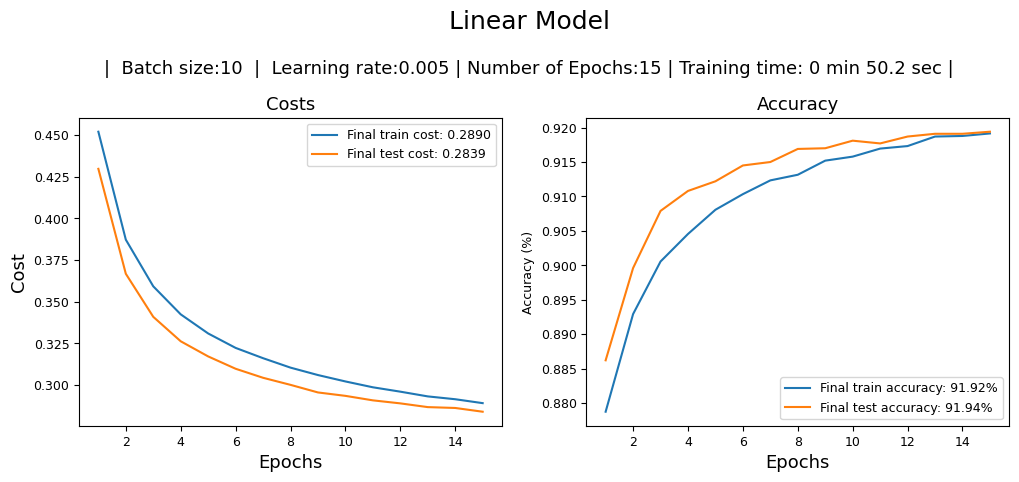

In [18]:
training_curve_plot("Linear Model", 
                    train_cost_lin, 
                    test_costs_lin, 
                    train_acc_lin, 
                    test_acc_lin, 
                    batch, 
                    lr, 
                    epochs, 
                    time_lin)

#### Multilayer Model

In [24]:
# Number of hidden layers
K = 4
# Number of neurons per layer
D = 200
# Input layer dimension
D_i = 784
# Output layer dimension
D_o = 10

W, B = initialize(K, D, D_i, D_o)
model_deep = Model(W, B)

epochs = 20
lr = 0.001
batch = 32
activation = "relu"

mt_deep, train_acc_deep, test_acc_deep, train_cost_deep, test_cost_deep, time_deep = train_model(X_train, 
                                                                                                 Y_train, 
                                                                                                 X_test, 
                                                                                                 Y_test, 
                                                                                                 model_deep, 
                                                                                                 activation,
                                                                                                 epochs, 
                                                                                                 lr, 
                                                                                                 batch)

Epoch 1/20 | Train acc: 0.8333 | Test acc: 0.8434 | Train cost: 0.6369| Test cost: 0.6162
Epoch 2/20 | Train acc: 0.8768 | Test acc: 0.8850 | Train cost: 0.4336| Test cost: 0.4163
Epoch 3/20 | Train acc: 0.8939 | Test acc: 0.8990 | Train cost: 0.3668| Test cost: 0.3528
Epoch 4/20 | Train acc: 0.9037 | Test acc: 0.9080 | Train cost: 0.3320| Test cost: 0.3213
Epoch 5/20 | Train acc: 0.9106 | Test acc: 0.9164 | Train cost: 0.3072| Test cost: 0.2968
Epoch 6/20 | Train acc: 0.9139 | Test acc: 0.9189 | Train cost: 0.2906| Test cost: 0.2824
Epoch 7/20 | Train acc: 0.9191 | Test acc: 0.9232 | Train cost: 0.2728| Test cost: 0.2662
Epoch 8/20 | Train acc: 0.9244 | Test acc: 0.9281 | Train cost: 0.2591| Test cost: 0.2540
Epoch 9/20 | Train acc: 0.9268 | Test acc: 0.9289 | Train cost: 0.2483| Test cost: 0.2451
Epoch 10/20 | Train acc: 0.9301 | Test acc: 0.9306 | Train cost: 0.2397| Test cost: 0.2376
Epoch 11/20 | Train acc: 0.9320 | Test acc: 0.9333 | Train cost: 0.2327| Test cost: 0.2318
Epoch 12

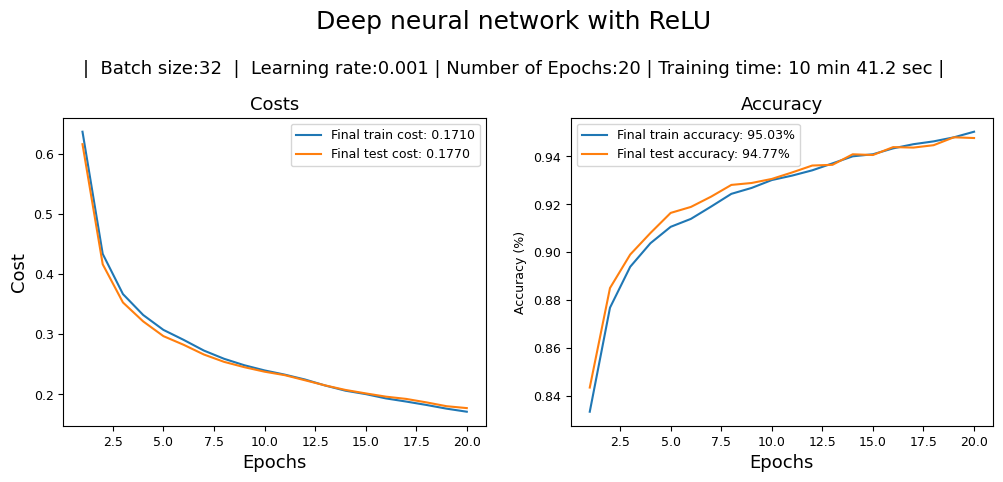

In [25]:
training_curve_plot("Deep neural network with ReLU", 
                    train_cost_deep, 
                    test_cost_deep, 
                    train_acc_deep, 
                    test_acc_deep, 
                    batch, 
                    lr, 
                    epochs, 
                    time_deep)


In [27]:
mt_deep.W

[array([[-0.0096289 ,  0.01649875,  0.04959741, ...,  0.04111809,
         -0.00348419,  0.02128222],
        [ 0.10522857, -0.00935686, -0.05216326, ...,  0.03775482,
         -0.04547537, -0.04576394],
        [ 0.06811456,  0.08127318, -0.06021326, ...,  0.03556794,
          0.00617658, -0.01200848],
        ...,
        [-0.0075611 , -0.04209449, -0.00840711, ...,  0.08521895,
          0.08145824,  0.02979124],
        [ 0.03152796,  0.00385456,  0.01776257, ..., -0.04475326,
          0.02086562, -0.09210897],
        [ 0.01698151, -0.02477337, -0.04655505, ...,  0.10259134,
          0.07994832,  0.00217788]], shape=(200, 784)),
 array([[ 0.20460722, -0.10732621,  0.06117268, ...,  0.04101639,
          0.04733004,  0.02964867],
        [-0.0663169 ,  0.0568399 ,  0.02398108, ...,  0.0007904 ,
         -0.20259983, -0.18005245],
        [ 0.04393739,  0.09379887,  0.1227545 , ..., -0.01121743,
         -0.03302019,  0.09684684],
        ...,
        [-0.22850074,  0.09433658,  

In [ ]:
type(mt_deep.W[0])

numpy.ndarray

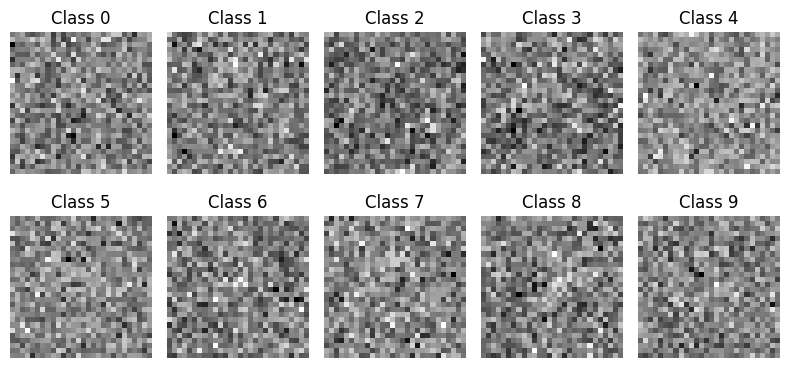

In [28]:
plt.figure(figsize=(8, 4))

for i in range(10):
    plt.subplot(2, 5, i + 1)            # 2 rows, 5 columns
    img = mt_deep.W[0][i].reshape(28, 28)          # reshape row to 28×28
    plt.imshow(img, cmap='gray')
    plt.title(f"Class {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

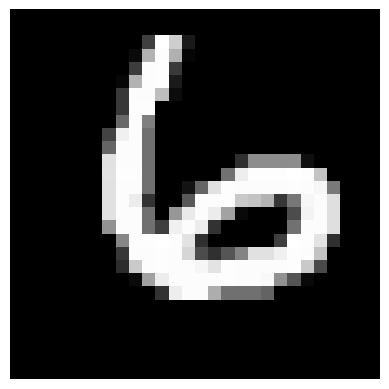

In [166]:


# take first training sample
img = sample.reshape(28, 28)

plt.imshow(img, cmap='gray')
plt.axis('off')   # hide axes
plt.show()

In [ ]:
# Number of hidden layers
K = 5
# Number of neurons per layer
D = 100
# Input layer dimension
D_i = 784
# Output layer dimension
D_o = 10

W, B = initialize(K, D, D_i, D_o)
model_deep2 = Model(W, B)

epochs = 20
lr = 0.001
batch = 32
activation = "sigmoid"

mt_deep2, train_acc_deep2, test_acc_deep2, train_cost_deep2, test_cost_deep2, time_deep2 = train_model(X_train, 
                                                                                                 Y_train, 
                                                                                                 X_test, 
                                                                                                 Y_test, 
                                                                                                 model_deep2, 
                                                                                                 activation,
                                                                                                 epochs, 
                                                                                                 lr, 
                                                                                                 batch)

Epoch 1/20 | Train acc: 0.0828 | Test acc: 0.0855 | Train cost: 2.4066| Test cost: 2.4062
Epoch 2/20 | Train acc: 0.0843 | Test acc: 0.0881 | Train cost: 2.4041| Test cost: 2.4036
Epoch 3/20 | Train acc: 0.0823 | Test acc: 0.0857 | Train cost: 2.4022| Test cost: 2.4015
Epoch 4/20 | Train acc: 0.0823 | Test acc: 0.0853 | Train cost: 2.4006| Test cost: 2.3999


In [ ]:
training_curve_plot("Deep neural network with ReLU", 
                    train_cost_deep2, 
                    test_cost_deep2, 
                    train_acc_deep2, 
                    test_acc_deep2, 
                    batch, 
                    lr, 
                    epochs, 
                    time_deep2)
